# Training method 2
In this notebook, we will try to complete 1 full round of research for a short piece of A13 highway from Rotterdam to Delft, with data from the month october.
- Loading NDW loopdata, and filtering the correct data from that.
- Adding the correct MSI information to all rows.
- Using pytorch to trian a neural network (NN) that can predict FR parameters from MSI data.
- Applying that NN to "normal" MSI data, and "altered" MSI data.
- Running a traffic simulation, and comparing the results.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import godunovfunctions
from tqdm.notebook import tqdm

In [3]:
# Define paths
datafolder = os.path.join(os.path.dirname(os.getcwd()), "data", "a13_2_months")
datafolder_msi = os.path.join(datafolder, "msi-export")
msi_path = os.path.join(datafolder_msi, "msi-export.csv")

datafolder_intensityspeed = os.path.join(datafolder, "intensiteit-snelheid-export")
intensityspeed_path = os.path.join(datafolder_intensityspeed, "intensiteit-snelheid-export.csv")

In [4]:
# Load data
IS_df = pd.read_csv(intensityspeed_path, low_memory=False)
MSI_df = pd.read_csv(msi_path, low_memory=False)

In [5]:
# Add columns
IS_df["gem_dichtheid"] = IS_df["gem_intensiteit"] / IS_df["gem_snelheid"]
MSI_df["time"] = pd.to_datetime(MSI_df["Datum en tijd beeldstandwijziging"])

In [6]:
# Filter out the relevant data in the intensity-speed df
IS_df = IS_df[IS_df.voertuigcategorie == "anyVehicle"]
IS_df = IS_df[IS_df.gem_snelheid != -1]
IS_df = IS_df[IS_df.technical_exclusion != "v"]    
IS_df["start"] = pd.to_datetime(IS_df.start_meetperiode)
mask = (IS_df.start.dt.time >= pd.to_datetime("7:00").time()) & (IS_df.start.dt.time < pd.to_datetime("19:00").time())
mask2 = (IS_df.start.dt.weekday != 5) & (IS_df.start.dt.weekday != 6)
IS_df = IS_df[mask & mask2]


In [7]:
# Aggregate the lanes together
filtered = IS_df[["start", "id_meetlocatie"]].drop_duplicates()
grouped = IS_df.groupby(["start", "id_meetlocatie"])
tot = grouped["gem_intensiteit"].transform("sum")
gem_snelheid_weighted = (IS_df["gem_snelheid"] / tot * IS_df["gem_intensiteit"]).groupby([IS_df["start"], IS_df["id_meetlocatie"]]).transform("sum")
filtered["gem_intensiteit"] = tot
filtered["gem_snelheid"] = gem_snelheid_weighted
filtered["gem_dichtheid"] = filtered["gem_intensiteit"] / filtered["gem_snelheid"]
IS_df = filtered

# Adding MSI data to the IS_df
We will need the hectometer location of all measuring points. This hectometer location (and direction R/L) can be found from the measuring location id. For example:
RWS01_MONIBAS_0131hrl0117ra
- 013 means highway A13
- hrl means the L direction (otherwise hrr)
- 0117 means hectometer 11.7
- ra means the main road (otherwise rb, or maybe even rc)

The `find_road_situation` function is too slow, so I will write another function that adds MSI information to the whole dataframe in 1 sweep.

We will manually add the hectometer/direction to all locations, and then add that information to all rows. Then, we will make some plots to confirm the correct values.


In [8]:
# Add direction and hectometer information
direction_dict = {}
hectometer_dict = {}
for i in IS_df.id_meetlocatie.unique():
    if i[6:13] == "MONIBAS":
        if i[14:18] == "0131":
            direction_dict[i] = i[20].upper()
            hectometer_dict[i] = int(i[21:25]) / 10
    else:
        raise NameError(f"Please clarify id {i}")

In [11]:
def add_MSI_information(IS_loc_df, MSI_df, hectometer, direction, max_speed=100.0, num_lanes=6):
    # In this function, IS_loc_df is the subset of IS_df with only the data of 1 location. 
    # We will create num_lanes=6 empty columns of return_df, with the same number of rows as loc_df
    return_df = pd.DataFrame()

    # Find closest location, call it "closest_measuring_location"
    dir_df = MSI_df[MSI_df["DVK"] == direction]
    hm_points = dir_df.Hectometrering.unique()
    try:
        if direction == "R": 
            closest_measuring_location = max(hm_points[hm_points <= hectometer])
        else:
            closest_measuring_location = min(hm_points[hm_points >= hectometer])
    except ValueError:
        print(f'ERROR: Matrix data unknown for measuring point {IS_loc_df["id_meetlocatie"].unique()[0]}\nat hectometer {hectometer}, direction {direction}.\nTry adding more MSI data.')
        for lane_nr in range(1, num_lanes+1):
            return_df[lane_nr] = [0] * len(IS_loc_df)
        return return_df
        # raise ValueError(f"Matrix data unknown for measuring point at hectometer {hectometer}.\nTry adding more MSI data.")
    # Only look at the closest location
    loc_df = dir_df[dir_df["Hectometrering"] == closest_measuring_location]
    # print(loc_df)
    # Define MSI configs:
    MSIconfigs = {
        "blank": max_speed,
        "lane_closed_ahead merge_left": max_speed,
        "lane_closed_ahead merge_right": max_speed,
        "restriction_end": max_speed,
        "lane_closed": 0,
        "speedlimit 100": 100,
        "speedlimit 80": 80,
        "speedlimit 70": 70,
        "speedlimit 60": 60, 
        "speedlimit 50": 50,
        "speedlimit 30": 30,
        "unknown": max_speed,
        "speedlimit 90": 90,
    }

    for lane_nr in range(1, num_lanes+1):
        # If there is no lane_nr in the closest location, then there is no lane. 
        # Set max speed equal to 0 for the whole time on this lane
        lane_df = loc_df[loc_df["Rijstrook"] == lane_nr]
        if lane_df.empty:
            return_df[lane_nr] = [0] * len(IS_loc_df)
            continue
                
        # Now, for every row in IS_loc_df, find the latest update time
        change_times = lane_df.time
        last_update_time = change_times.iloc[0]
        last_update = MSIconfigs[lane_df[change_times == last_update_time]["Beeldstand"].values[0]]
        next_update_time = change_times.iloc[1]
        column = []
        for measure_time in IS_loc_df["start"]:
            if measure_time < next_update_time:
                column.append(last_update)
            else:
                last_update_time = max(lane_df[change_times <= measure_time].time)
                last_update = MSIconfigs[lane_df[change_times == last_update_time]["Beeldstand"].values[0]]
                next_times = lane_df[change_times > measure_time].time
                if next_times.empty:
                    next_update_time = max(IS_loc_df.start)
                else:
                    next_update_time = min(next_times)
                column.append(last_update)
            # beeldstand = lane_df[change_times == latest_update_time]["Beeldstand"].values[0]
            # column.append(MSIconfigs[beeldstand])
        return_df[lane_nr] = column
    return return_df

In [12]:
# Get all MSI information on all IS_df locations
IS_df = IS_df[IS_df["id_meetlocatie"] != "RWS01_MONIBAS_0131hrr0119ra"]
results = pd.DataFrame()
for measuring_location in IS_df["id_meetlocatie"].unique():
    hectometer = hectometer_dict[measuring_location]
    direction = direction_dict[measuring_location]
    ret = add_MSI_information(IS_df[IS_df["id_meetlocatie"] == measuring_location], MSI_df, hectometer, direction)
    results = pd.concat([results, ret])


In [13]:
# Combine all MSI information on all IS_df locations into df
df = pd.concat([IS_df.reset_index(), results.reset_index()], axis=1)

Now we will check if this dataframe is correct by taking a random sample of 100, and checking the MSI information on these locations.

In [14]:
random_rows = df.sample(n=100, random_state=0)
for index, row in random_rows.iterrows():
    hectometer = hectometer_dict[row["id_meetlocatie"]]
    direction = direction_dict[row["id_meetlocatie"]]
    road_situation = godunovfunctions.find_road_situation(
        hectometer=hectometer, 
        measure_time=row["start"], 
        MSI_df=MSI_df,
        direction=direction,
        )
    for i, val in enumerate(row[[1, 2, 3, 4, 5, 6]].tolist()):
        if val != road_situation[i]:
            raise ValueError(f"Row {index} is not matching!!!! This means the code is not right")


KeyError: 'Beeldstand unknown is not known.'

In [37]:
import torch
torch.save(df, "df_a13_2_months.pth")

# Neural network
This part has a few steps:
1. Creating a trainable neural network in pytorch with the correct layout
2. Training this neural network on the data we have just created (in df)
3. Applying this neural network to test data, and verifying the results

In [36]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(6, 4),
            nn.Softplus(),
            nn.Linear(4, 3),
            nn.Softplus()
        )
    
    def forward(self, x):
        fr_params = self.linear_stack(x[:, :6])
        
        u0 = fr_params[:, 0]
        qj = fr_params[:, 1]
        qc = fr_params[:, 2]

        q = x[:, -1]

        f_pred = u0 / qj * (qc * qj - qc * qc + (qc + q - qj) * F.relu(qc - q) - qc * F.relu(q - qc))
        return F.relu(f_pred)
    
    # def _initialize_parameters(self):
    #     for fc1 in self.linear_stack:
    #         torch.nn.init.zeros_(self.fc1.bias)
    #         torch.nn.init.xavier_uniform_(self.fc1.weight)
    
    def get_params(self, x):
        fr_params = self.linear_stack(x[:, :-1])
        return fr_params


In [17]:
# Initialize data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train_df = train_df[[1, 2, 3, 4, 5, 6, "gem_dichtheid"]]
Y_train_df = train_df["gem_intensiteit"]
X_test_df = test_df[[1, 2, 3, 4, 5, 6, "gem_dichtheid"]]
Y_test_df = test_df["gem_intensiteit"]


In [18]:
# Normalize data and create tensors
X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32) / 100.0
Y_train_tensor = torch.tensor(Y_train_df.values, dtype=torch.float32).view(-1) / 10000.0

X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32) / 100.0
Y_test_tensor = torch.tensor(Y_test_df.values, dtype=torch.float32).view(-1) / 10000.0

In [22]:
# Set up model and optimizer
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [23]:
epochs = 5000
# for g in optimizer.param_groups:
#     g['lr'] = 0.001

for epoch in range(epochs):
    predictions = model(X_train_tensor)
    loss = criterion(predictions, Y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # if (epoch + 1) % 500 == 0:
    #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    for name, param in model.named_parameters():
        print(f'Parameter: {name}, Gradient: {param.grad}')

Epoch [1/5000], Loss: nan
Parameter: linear_stack.0.weight, Gradient: tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])
Parameter: linear_stack.0.bias, Gradient: tensor([nan, nan, nan, nan])
Parameter: linear_stack.2.weight, Gradient: tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]])
Parameter: linear_stack.2.bias, Gradient: tensor([nan, nan, nan])
Epoch [2/5000], Loss: nan
Parameter: linear_stack.0.weight, Gradient: tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])
Parameter: linear_stack.0.bias, Gradient: tensor([nan, nan, nan, nan])
Parameter: linear_stack.2.weight, Gradient: tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]])
Parameter: linear_stack.2.bias, Gradient: tensor([nan, nan, 

KeyboardInterrupt: 

In [18]:
test_MSI_info = [
    100, 
    100, 
    100, 
    0, 
    0, 
    0
]

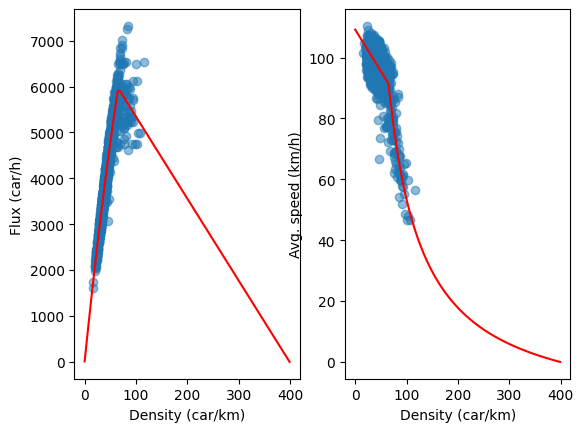

In [19]:
# Apply model to test_MSI_info
fr_params = model.get_params(torch.tensor([test_MSI_info + [0]], dtype=torch.float)/100)
qj = float(fr_params[0, 1] * 100)

subset_IS_df = test_df[(test_df[[1, 2, 3, 4, 5, 6]] == test_MSI_info).all(axis=1)]
test_density = subset_IS_df["gem_dichtheid"]
test_flux = subset_IS_df["gem_intensiteit"]
test_speed = subset_IS_df["gem_snelheid"]

model_density = np.linspace(0.1, qj, 100)
model_flux = []
def get_model_f(model, max_speeds, density):
    X = max_speeds + [density]
    X = torch.tensor([X], dtype=torch.float)
    X = X/100
    y = model(X)
    y = float(y)
    return y*10000

for i in model_density:
    model_flux.append(get_model_f(model, test_MSI_info, i))
model_flux = np.array(model_flux)
model_speed = model_flux / model_density

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(test_density, test_flux, alpha=0.5)
ax1.plot(model_density, model_flux, "r")
ax1.set_xlabel('Density (car/km)')
ax1.set_ylabel("Flux (car/h)")
ax2.scatter(test_density, test_speed, alpha=0.5)
ax2.plot(model_density, model_speed, "r")
ax2.set_xlabel("Density (car/km)")
ax2.set_ylabel("Avg. speed (km/h)")
plt.show()